In [1]:
import pandas as pd

data = {
    "CustomerID": [101, 102, 101, 103, 104, 102, 101, 105],
    "InvoiceDate": [
        "2024-01-10", "2024-01-12", "2024-02-05",
        "2024-02-07", "2024-03-01", "2024-03-15",
        "2024-04-10", "2024-04-12"
    ],
    "Amount": [500, 300, 700, 200, 1000, 400, 600, 150]
}

df = pd.DataFrame(data)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df


,CustomerID,InvoiceDate,Amount
0,101,2024-01-10,500
1,102,2024-01-12,300
2,101,2024-02-05,700
3,103,2024-02-07,200
4,104,2024-03-01,1000
5,102,2024-03-15,400
6,101,2024-04-10,600
7,105,2024-04-12,150


In [2]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   8 non-null      int64         
 1   InvoiceDate  8 non-null      datetime64[ns]
 2   Amount       8 non-null      int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 324.0 bytes


,CustomerID,InvoiceDate,Amount
count,8.000000,8,8.000000
mean,102.375000,2024-02-23 12:00:00,481.250000
min,101.000000,2024-01-10 00:00:00,150.000000
25%,101.000000,2024-01-30 00:00:00,275.000000
50%,102.000000,2024-02-18 12:00:00,450.000000
75%,103.250000,2024-03-21 12:00:00,625.000000
max,105.000000,2024-04-12 00:00:00,1000.000000
std,1.505941,NaN,282.763783


In [3]:
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
reference_date


Timestamp('2024-04-13 00:00:00')

In [4]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "CustomerID": "count",
    "Amount": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm


,Recency,Frequency,Monetary
CustomerID,,,
101,3,3,1800
102,29,2,700
103,66,1,200
104,43,1,1000
105,1,1,150


In [7]:
rfm["R_Score"] = pd.cut(rfm["Recency"], bins=3, labels=[3, 2, 1])
rfm["F_Score"] = pd.cut(rfm["Frequency"], bins=3, labels=[1, 2, 3])
rfm["M_Score"] = pd.cut(rfm["Monetary"], bins=3, labels=[1, 2, 3])

rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str)
    + rfm["F_Score"].astype(str)
    + rfm["M_Score"].astype(str)
)

rfm


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
101,3,3,1800,3,3,3,333
102,29,2,700,2,2,1,221
103,66,1,200,1,1,1,111
104,43,1,1000,2,1,2,212
105,1,1,150,3,1,1,311


In [8]:
def segment_customer(score):
    score = int(score)
    if score >= 322:
        return "High Value"
    elif score >= 211:
        return "Medium Value"
    else:
        return "Low Value"

rfm["Segment"] = rfm["RFM_Score"].apply(segment_customer)
rfm


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
CustomerID,,,,,,,,
101,3,3,1800,3,3,3,333,High Value
102,29,2,700,2,2,1,221,Medium Value
103,66,1,200,1,1,1,111,Low Value
104,43,1,1000,2,1,2,212,Medium Value
105,1,1,150,3,1,1,311,Medium Value


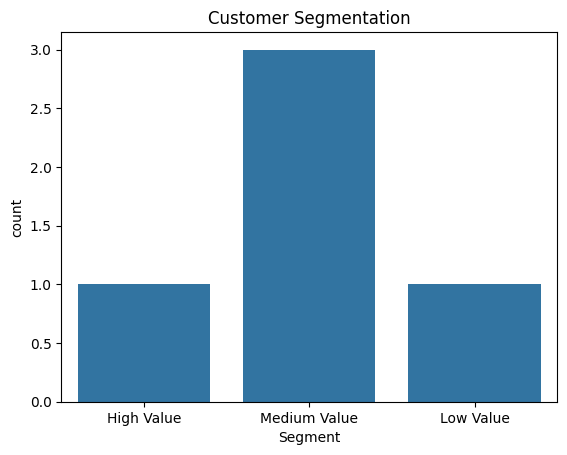

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Segment", data=rfm.reset_index())
plt.title("Customer Segmentation")
plt.show()


### Business Insights
- High Value customers purchase frequently and contribute the most revenue.
- Medium Value customers show potential to become high value with offers.
- Low Value customers have low frequency and low spending.